* https://rhodesmill.org/skyfield/
* https://rhodesmill.org/skyfield/earth-satellites.html

In [53]:
%pip install matplotlib pandas


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [33]:
from skyfield.api import load, wgs84, Loader
from skyfield import almanac, framelib
from skyfield.units import AngleRate, Angle
import math
import matplotlib.pyplot as plt
import pandas as pd
from pytz import timezone
from datetime import datetime
from matplotlib.dates import HourLocator, DateFormatter
from astropy.table import Table, hstack
from skyfield.units import Angle, Distance, AngleRate, Velocity
from skyfield.timelib import Time
from numpy.lib.type_check import nan_to_num
from geopy.geocoders import Nominatim

eph = load('de421.bsp')
stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle'
satellites = load.tle_file(stations_url)
print('Loaded', len(satellites), 'satellites')

Loaded 7317 satellites


In [54]:
by_name = { s.name: s for s in satellites }
#satellite = by_name['ISS (ZARYA)')
#satellite = by_name['BLUEWALKER 3']
satellite = by_name['STARLINK-1014']
print(satellite)

STARLINK-1014 catalog #44720 epoch 2023-02-12 18:38:26 UTC


In [55]:
#geolocator = Nominatim()
#location = geolocator.geocode("3048 Farrior Road, Raleigh, NC 27607")

#location

In [56]:
tz = timezone('US/Eastern')

earth = eph['earth']
sun = eph['sun']
raleigh = wgs84.latlon(35.807185453343514, -78.6761513684278)
# raleigh = wgs84.latlon(location.latitude, location.longitude)
difference = satellite - raleigh

In [64]:
def event_data(t, event, satellite, eph):
    name = ('rise', 'peak', 'set')[event]
    topocentric = difference.at(t)
    alt, az, _ = topocentric.altaz()
    ra, dec, _ = topocentric.radec()

    return {
        'timestamp': t.astimezone(tz),
        'event': name,
        'altitude': alt.degrees,
        'azimuth': az.degrees,
        'ra': ra.hours,
        'dec': dec.degrees,
        'is_sunlit': satellite.at(t).is_sunlit(eph)
    }

In [66]:
ts = load.timescale()

t0 = ts.from_datetime(tz.localize(datetime.now())) - .1
t1 = t0 + 3
t, events = satellite.find_events(raleigh, t0, t1, altitude_degrees=5)
tod = almanac.dark_twilight_day(eph, raleigh)

data = pd.DataFrame.from_records([event_data(t,event,satellite,eph) for t, event in zip(t, events)],
                                 columns = ("timestamp", "event", "alt", "az", "ra", "dec", "is_sunlit"), index='timestamp')

data['time_of_day'] = [almanac.TWILIGHTS[x] for x in tod(t)]
data['is_dark'] = [ x<=3 for x in tod(t)]

data

,event,alt,az,ra,dec,is_sunlit,time_of_day,is_dark
timestamp,,,,,,,,
2023-02-16 02:07:44.377727-05:00,rise,NaN,NaN,12.230371,-48.636268,False,Night,True
2023-02-16 02:11:34.522164-05:00,peak,NaN,NaN,15.424151,-16.646855,False,Night,True
2023-02-16 02:15:25.369876-05:00,set,NaN,NaN,18.051490,15.157008,False,Night,True
2023-02-16 03:45:37.644161-05:00,rise,NaN,NaN,8.954503,-23.626581,False,Night,True
2023-02-16 03:50:40.665088-05:00,peak,NaN,NaN,10.974818,54.486515,False,Night,True
...,...,...,...,...,...,...,...,...
2023-02-18 10:21:04.241678-05:00,peak,NaN,NaN,19.850944,34.130368,True,Day,False
2023-02-18 10:26:09.627348-05:00,set,NaN,NaN,23.714464,-32.061491,True,Day,False
2023-02-18 11:57:13.913582-05:00,rise,NaN,NaN,15.807529,3.958514,True,Day,False


In [10]:
passes = []

curr = None
for event in [event_data(t,event,satellite,eph) for t, event in zip(t, events)]:
    if event['event']=='rise':
        curr = {'rise': event}
    elif event['event']=='peak':
        curr['peak'] = event
    elif event['event']=='set':
        curr['set'] = event
        passes.append(curr)

In [11]:
almanac.dark_twilight_day(eph, raleigh)

<function skyfield.almanac.dark_twilight_day.<locals>.is_it_dark_twilight_day_at(t)>

In [12]:
f = almanac.dark_twilight_day(eph, raleigh)
times, events = almanac.find_discrete(t0, t1, f)

previous_e = f(t0).item()
for t, e in zip(times, events):
    tstr = str(t.astimezone(tz))[:16]
    if previous_e < e:
        print(tstr, ' ', almanac.TWILIGHTS[e], 'starts')
    else:
        print(tstr, ' ', almanac.TWILIGHTS[previous_e], 'ends')
    previous_e = e

2023-02-15 19:22   Astronomical twilight ends
2023-02-16 05:35   Astronomical twilight starts
2023-02-16 06:04   Nautical twilight starts
2023-02-16 06:34   Civil twilight starts
2023-02-16 07:00   Day starts
2023-02-16 17:57   Day ends
2023-02-16 18:23   Civil twilight ends
2023-02-16 18:53   Nautical twilight ends
2023-02-16 19:22   Astronomical twilight ends
2023-02-17 05:34   Astronomical twilight starts
2023-02-17 06:03   Nautical twilight starts
2023-02-17 06:33   Civil twilight starts
2023-02-17 06:59   Day starts
2023-02-17 17:58   Day ends
2023-02-17 18:24   Civil twilight ends
2023-02-17 18:54   Nautical twilight ends
2023-02-17 19:23   Astronomical twilight ends
2023-02-18 05:32   Astronomical twilight starts
2023-02-18 06:02   Nautical twilight starts
2023-02-18 06:32   Civil twilight starts
2023-02-18 06:58   Day starts
2023-02-18 17:59   Day ends
2023-02-18 18:25   Civil twilight ends
2023-02-18 18:55   Nautical twilight ends


In [13]:
events

array([0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 4, 3,
       2, 1])

In [26]:
difference.at(times[1]).is_sunlit(eph)

True

In [15]:
alt, az, distance, alt_rate, az_rate, range_rate = difference.at(times[1]).frame_latlon_and_rates(raleigh)

rate = AngleRate._from_radians_per_day(
    math.sqrt(alt_rate.radians.per_day**2 + az_rate.radians.per_day**2))

print('Alt: {:.2f} degrees'.format(alt.degrees))
print('Az: {:.2f} degrees'.format(az.degrees))
print('Distance: {:.2f} km'.format(distance.km))
print('Alt Rate: {:+.2f} arcmin/s'.format(alt_rate.arcminutes.per_second))
print('Az Rate:  {:+.2f} arcmin/s'.format(az_rate.arcminutes.per_second))
print('Total Rate: {:.2f} arcmin/s'.format(rate.arcminutes.per_second))
print('Range rate: {:+.2f} km/s'.format(range_rate.km_per_s))

Alt: 3.55 degrees
Az: 26.97 degrees
Distance: 2344.94 km
Alt Rate: -3.07 arcmin/s
Az Rate:  +7.35 arcmin/s
Total Rate: 7.96 arcmin/s
Range rate: +4.87 km/s


In [49]:
#x = ts.linspace(ts.utc(2023,2,12,12,52,59), ts.utc(2023,2,12,12,58,13), 200)
#x = ts.linspace(ts.utc(2023,2,17,10,21,57), ts.utc(2023,2,17,10,25,57), 200)
x = ts.linspace(ts.utc(2023,2,10,10,57,35), ts.utc(2023,2,10,11,4,10), 200)
detail = [(t, *difference.at(t).frame_latlon_and_rates(raleigh), difference.at(t).is_sunlit(eph)) for t in x]
detail = [(*row, AngleRate._from_radians_per_day(math.sqrt(row[4].radians.per_day**2 + row[5].radians.per_day**2))) for row in detail]
x = x.astimezone(tz)

pass_table = Table(rows=detail,
                    names=('ts', 'alt', 'az', 'distance', 'alt_rate', 'az_rate', 'range_rate', 'is_sunlit', 'angular_rate'),
                    dtype=(Time, Angle, Angle, Distance, AngleRate, AngleRate, Velocity, bool, AngleRate))

In [50]:
pass_table

ts,alt,az,distance,alt_rate,az_rate,range_rate,is_sunlit,angular_rate
object,object,object,object,object,object,object,bool,object
<Time tt=2459985.9574558334>,"-12deg 19' 46.9""","233deg 16' 48.6""",2.92701e-05 au,<skyfield.units.AngleRate object at 0x13cd22dd0>,<skyfield.units.AngleRate object at 0x13e25ead0>,-0.00376454 au/day,False,<skyfield.units.AngleRate object at 0x13e2ebbe0>
<Time tt=2459985.957478807>,"-12deg 14' 50.7""","233deg 18' 11.9""",2.91836e-05 au,<skyfield.units.AngleRate object at 0x13e25ec20>,<skyfield.units.AngleRate object at 0x13e25f0d0>,-0.00376559 au/day,False,<skyfield.units.AngleRate object at 0x13e2ebb50>
<Time tt=2459985.9575017807>,"-12deg 09' 54.0""","233deg 19' 35.5""",2.90971e-05 au,<skyfield.units.AngleRate object at 0x13e25e0e0>,<skyfield.units.AngleRate object at 0x13e25f160>,-0.00376663 au/day,False,<skyfield.units.AngleRate object at 0x13e2ebca0>
<Time tt=2459985.957524754>,"-12deg 04' 56.8""","233deg 20' 59.6""",2.90105e-05 au,<skyfield.units.AngleRate object at 0x13e25f220>,<skyfield.units.AngleRate object at 0x13e25e080>,-0.00376767 au/day,False,<skyfield.units.AngleRate object at 0x13e2ebdc0>
<Time tt=2459985.957547728>,"-11deg 59' 59.1""","233deg 22' 24.1""",2.89239e-05 au,<skyfield.units.AngleRate object at 0x13e25d180>,<skyfield.units.AngleRate object at 0x13e25f550>,-0.0037687 au/day,False,<skyfield.units.AngleRate object at 0x13e2ebee0>
<Time tt=2459985.957570702>,"-11deg 55' 01.0""","233deg 23' 49.0""",2.88374e-05 au,<skyfield.units.AngleRate object at 0x13e25ef20>,<skyfield.units.AngleRate object at 0x13e219e10>,-0.00376972 au/day,False,<skyfield.units.AngleRate object at 0x13e2fc040>
<Time tt=2459985.9575936752>,"-11deg 50' 02.3""","233deg 25' 14.3""",2.87507e-05 au,<skyfield.units.AngleRate object at 0x13e218220>,<skyfield.units.AngleRate object at 0x13e219cf0>,-0.00377073 au/day,False,<skyfield.units.AngleRate object at 0x13e2fc160>
<Time tt=2459985.957616649>,"-11deg 45' 03.2""","233deg 26' 40.1""",2.86641e-05 au,<skyfield.units.AngleRate object at 0x13e23bc40>,<skyfield.units.AngleRate object at 0x13e23bee0>,-0.00377174 au/day,False,<skyfield.units.AngleRate object at 0x13e2fc280>
<Time tt=2459985.9576396225>,"-11deg 40' 03.5""","233deg 28' 06.3""",2.85774e-05 au,<skyfield.units.AngleRate object at 0x13e23ad40>,<skyfield.units.AngleRate object at 0x13e23a7a0>,-0.00377274 au/day,False,<skyfield.units.AngleRate object at 0x13e2fc3a0>


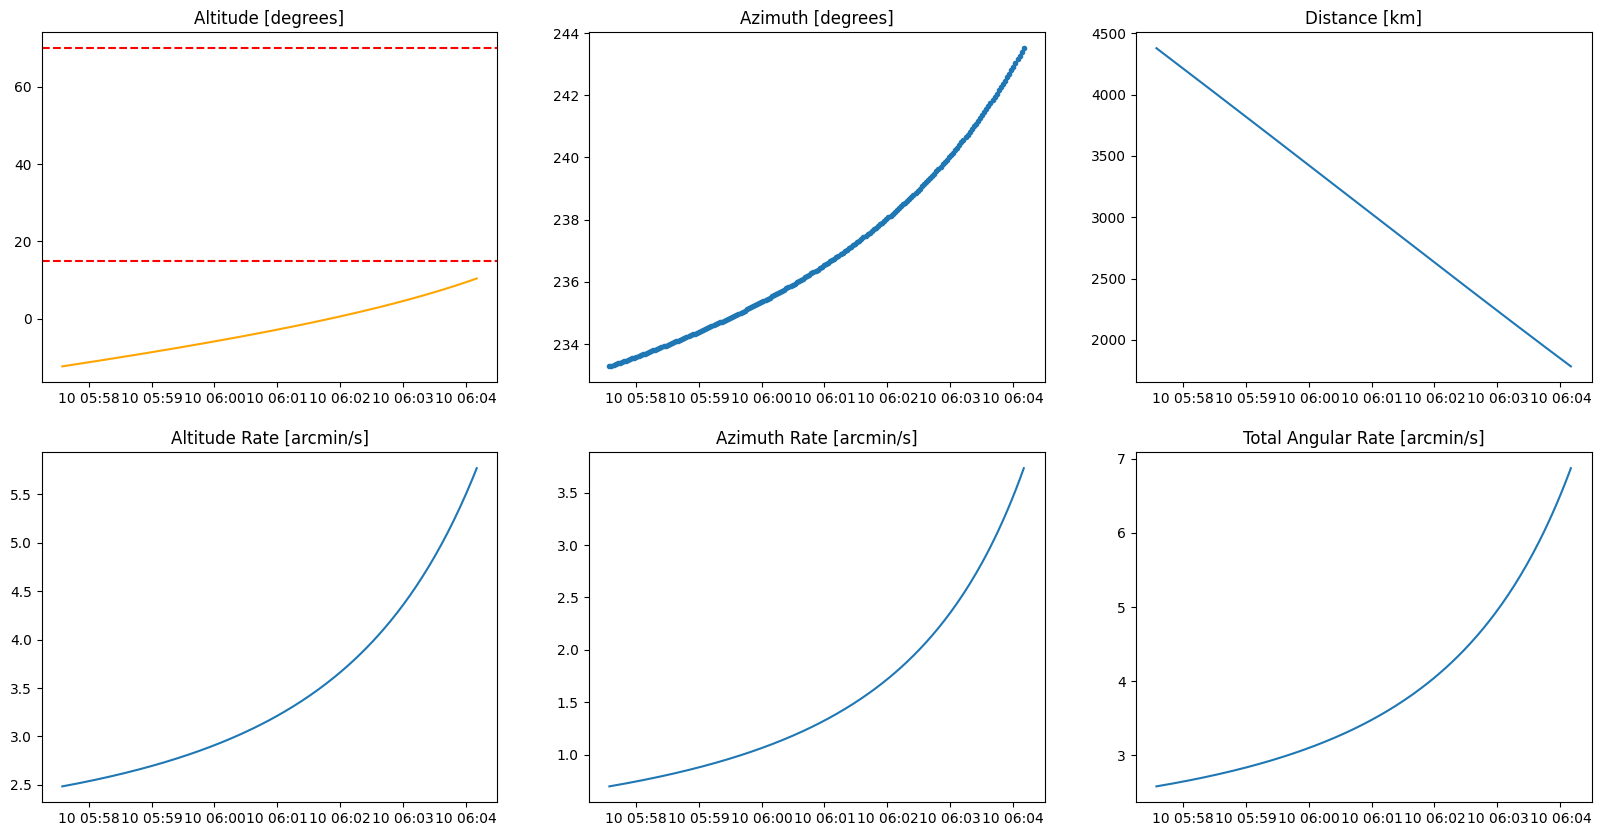

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

ax[0][0].plot([r['ts'].astimezone(tz) for r in pass_table if r['is_sunlit']],
              [r['alt'].degrees for r in pass_table if r['is_sunlit']])
ax[0][0].plot([r['ts'].astimezone(tz) for r in pass_table if not r['is_sunlit']],
              [r['alt'].degrees for r in pass_table if not r['is_sunlit']],
              color='orange')
ax[0][0].axhline(y=15, color='red', linestyle='--')
ax[0][0].axhline(y=70, color='red', linestyle='--')
ax[0][0].set_title("Altitude [degrees]")

ax[0][1].scatter([r['ts'].astimezone(tz) for r in pass_table], [az.degrees for az in pass_table['az']], marker='.')
ax[0][1].set_title("Azimuth [degrees]")

ax[0][2].plot([r['ts'].astimezone(tz) for r in pass_table], [dist.km for dist in pass_table['distance']])
ax[0][2].set_title("Distance [km]")

ax[1][0].plot([r['ts'].astimezone(tz) for r in pass_table], [alt_rate.arcminutes.per_second for alt_rate in pass_table['alt_rate']])
ax[1][0].set_title("Altitude Rate [arcmin/s]")

ax[1][1].plot([r['ts'].astimezone(tz) for r in pass_table], [az_rate.arcminutes.per_second for az_rate in pass_table['az_rate']]);
ax[1][1].set_title("Azimuth Rate [arcmin/s]")

#ax[1][2].plot(x, [range_rate.km_per_s for range_rate in pass_table['range_rate']]);
#ax[1][2].set_title("Range Rate [km/s]");

ax[1][2].plot([r['ts'].astimezone(tz) for r in pass_table], [rate.arcminutes.per_second for rate in pass_table['angular_rate']]);
ax[1][2].set_title("Total Angular Rate [arcmin/s]");


In [52]:
import requests
import json
import base64

r = requests.get('https://ssd.jpl.nasa.gov/api/horizons.api', params={
'MAKE_EPHEM': 'YES',
'COMMAND': '\'DES=3727039;\'',
'EPHEM_TYPE': 'SPK',
'OBJ_DATA': 'NO',
'START_TIME': '2020-01-01',
'STOP_TIME': '2030-12-31',
})

print(r.url)

res = json.loads(r.content)
with open('2015RN35.bsp', 'w+b') as f:
  f.write(base64.b64decode(res['spk']))

ModuleNotFoundError: No module named 'requests'

In [ ]:
from spktype21 import SPKType21
from skyfield.constants import AU_KM
from skyfield.vectorlib import VectorFunction

class Type21Object(VectorFunction):
    def __init__(self, kernel, target):
        self.kernel = kernel
        self.center = 10
        self.target = target

    def _at(self, t):
        k = self.kernel
        r, v = k.compute_type21(10, self.target, t.whole, t.tdb_fraction)
        return r / AU_KM, v / AU_KM, None, None

kernel = SPKType21.open('2015RN35.bsp')
rn35 = sun + Type21Object(kernel, 3727039)

In [ ]:

sun

<ChebyshevPosition 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN>

In [ ]:
rn35

<VectorSum of 2 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
 Type21Object 10 SUN -> 3727039>

In [ ]:
t = ts.utc(2022,12,18,5,0)

obs = (earth+raleigh).at(t).observe(rn35)

alt, az, distance, alt_rate, az_rate, range_rate = obs.frame_latlon_and_rates(raleigh)
_, _, _, dec_rate, ra_rate, _ = obs.frame_latlon_and_rates(framelib.true_equator_and_equinox_of_date)
ra, dec, _ = obs.radec()

altaz_rate = AngleRate._from_radians_per_day(
    math.sqrt(alt_rate.radians.per_day**2 + az_rate.radians.per_day**2))

radec_rate = AngleRate._from_radians_per_day(
    math.sqrt(ra_rate.radians.per_day**2 + dec_rate.radians.per_day**2))

print(f'Ra:  {ra}')
print(f'Dec: {dec}')
print(f'Ra Rate: {ra_rate.arcminutes.per_minute:+.2f} arcmin/min')
print(f'Dec Rate:  {dec_rate.arcminutes.per_minute:+.2f} arcmin/min')
print(f'Angular Velocity: {radec_rate.arcminutes.per_minute:.2f} arcmin/min')
print()
print(f'Alt: {alt.degrees:.2f} degrees')
print(f'Az:  {az.degrees:.2f} degrees')
print(f'Alt Rate: {alt_rate.arcminutes.per_minute:+.2f} arcmin/min')
print(f'Az Rate:  {az_rate.arcminutes.per_minute:+.2f} arcmin/min')
print(f'Total Alt/Az Rate: {altaz_rate.arcminutes.per_minute:.2f} arcmin/min')
print(f'Distance: {distance.au:.2f} AU')

In [ ]:
(earth+raleigh).at(t).observe(rn35).radec()

In [ ]:
(earth+raleigh).at(t+1/24/60).observe(rn35).radec()[0]._degrees

In [ ]:
ra._degrees - ra_rate.degrees.per_minute

In [ ]:
ra._degrees

In [ ]:
t+1/24/60

In [ ]:
altaz_rate.arcminutes.per_minute

In [ ]:
radec_rate.arcminutes.per_minute

In [ ]:
!wget https://www.minorplanetcenter.net/iau/MPCORB/MPCORB.DAT.gz

In [ ]:
!gunzip MPCORB.DAT.gz

In [ ]:
!grep ' 2015 RN35 ' MPCORB.DAT > MPCORB.excerpt.DAT

In [ ]:
from skyfield.data import mpc
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN

with load.open('MPCORB.excerpt.DAT') as f:
    minor_planets = mpc.load_mpcorb_dataframe(f)

print(minor_planets.shape[0], 'minor planets loaded')
bad_orbits = minor_planets.semimajor_axis_au.isnull()
minor_planets = minor_planets[~bad_orbits]
minor_planets = minor_planets.set_index('designation', drop=False)
minor_planets

In [ ]:
row = minor_planets.loc['2015 RN35']
rn35_mpc = sun + mpc.mpcorb_orbit(row, ts, GM_SUN)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from skyfield.api import Star, load
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection

# The comet is plotted on several dates `t_comet`.  But the stars only
# need to be drawn once, so we take the middle comet date as the single
# time `t` we use for everything else.

ts = load.timescale()
t_comet = ts.utc(2020, 7, range(17, 27))
t = t_comet[len(t_comet) // 2]  # middle date

# An ephemeris from the JPL provides Sun and Earth positions.

eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']

# The Minor Planet Center data file provides the comet orbit.

with load.open(mpc.COMET_URL) as f:
    comets = mpc.load_comets_dataframe(f)

comets = (comets.sort_values('reference')
          .groupby('designation', as_index=False).last()
          .set_index('designation', drop=False))

row = comets.loc['C/2020 F3 (NEOWISE)']
comet = sun + mpc.comet_orbit(row, ts, GM_SUN)

# The Hipparcos mission provides our star catalog.

with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

# And the constellation outlines come from Stellarium.  We make a list
# of the stars at which each edge stars, and the star at which each edge
# ends.

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/modern_iau/constellationship.fab')

with load.open(url) as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

# We will center the chart on the comet's middle position.

center = earth.at(t).observe(comet)
projection = build_stereographic_projection(center)
field_of_view_degrees = 45.0
limiting_magnitude = 7.0

# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the comet will have on the plot.

star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

comet_x, comet_y = projection(earth.at(t_comet).observe(comet))

# Create a True/False mask marking the stars bright enough to be
# included in our plot.  And go ahead and compute how large their
# markers will be on the plot.

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

# The constellation lines will each begin at the x,y of one star and end
# at the x,y of another.  We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

# Time to build the figure!

fig, ax = plt.subplots(figsize=[12, 12])

# Draw the constellation lines.

ax.add_collection(LineCollection(lines_xy, colors='#00f2'))

# Draw the stars.

ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k')

# Draw the comet positions, and label them with dates.

comet_color = '#f00'
offset = 0.002

ax.plot(comet_x, comet_y, '+', c=comet_color, zorder=3)

for xi, yi, tstr in zip(comet_x, comet_y, t_comet.utc_strftime('%m/%d')):
    tstr = tstr.lstrip('0')
    text = ax.text(xi + offset, yi - offset, tstr, color=comet_color,
                   ha='left', va='top', fontsize=9, weight='bold', zorder=-1)
    text.set_alpha(0.5)

# Finally, title the plot and set some final parameters.

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
ax.set_title('Comet NEOWISE {} through {}'.format(
    t_comet[0].utc_strftime('%Y %B %d'),
    t_comet[-1].utc_strftime('%Y %B %d'),
));